# SAREK VCF PROCESSING OF LUNG SAMPLE TO CALCULATE VAF

In [1]:
# Needed basic packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from matplotlib_venn import venn2

# 1/ Reading the VCF files and formating as dataframe

In [2]:
# IN THIS CASE WE WILL IMPORT DIRECTLY THE VCF body with "comment=#" to read the row after "#" where the vcf body starts
mutect_df = pd.read_csv("/workspace/projects/sjd_melos/var_call_output/sarek_results/variant_calling/mutect2/AX4941_vs_AB9766/AX4941_vs_AB9766.mutect2.filtered.vcf.gz", sep = "\t", comment='#', header=None) # for Mutect2 results
strelka_snv_df = pd.read_csv("/workspace/projects/sjd_melos/var_call_output/sarek_results/variant_calling/strelka/AX4941_vs_AB9766/AX4941_vs_AB9766.strelka.somatic_snvs.vcf.gz", sep = "\t", comment='#', header=None) # for Strelka SNV file
strelka_ind_df = pd.read_csv("/workspace/projects/sjd_melos/var_call_output/sarek_results/variant_calling/strelka/AX4941_vs_AB9766/AX4941_vs_AB9766.strelka.somatic_indels.vcf.gz", sep = "\t", comment='#', header=None) # for Strelka INDEL file

In [3]:
# Check file dimensions
print('Rows x Columns in Mutect2 file:', mutect_df.shape)
print('Rows x Columns in Strelka SNV file: ', strelka_snv_df.shape)
print('Rows x Columns in Strelka INDELs file:', strelka_ind_df.shape)

Rows x Columns in Mutect2 file: (268363, 11)
Rows x Columns in Strelka SNV file:  (1438960, 11)
Rows x Columns in Strelka INDELs file: (189358, 11)


In [4]:
# Rename columns of the dataframes according to VCF nomenclature
mutect_df.columns = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'patient1_AB9766', 'patient1_AX4941']
strelka_ind_df.columns = ['CHROM', 'POS','ID', 'REF','ALT', 'QUAL','FILTER', 'INFO','FORMAT', 'NORMAL','TUMOR']
strelka_snv_df.columns = ['CHROM', 'POS','ID', 'REF','ALT', 'QUAL','FILTER', 'INFO','FORMAT', 'NORMAL','TUMOR']				

In [5]:
mutect_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,patient1_AB9766,patient1_AX4941
0,chr1,16103,.,T,G,.,normal_artifact;strand_bias;weak_evidence,"AS_FilterStatus=weak_evidence,strand_bias;AS_S...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:199,7:0.038:206:82,3:104,4:197,7:100,99,6,1","0/1:130,4:0.038:134:54,3:52,1:125,4:69,61,4,0"
1,chr1,16125,.,T,G,.,normal_artifact;strand_bias;weak_evidence,"AS_FilterStatus=weak_evidence,strand_bias;AS_S...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:209,11:0.053:220:88,4:106,7:208,11:115,94,...","0/1:136,7:0.051:143:55,2:55,4:131,7:74,62,6,1"
2,chr1,16288,.,C,G,.,map_qual;normal_artifact;strand_bias;weak_evid...,"AS_FilterStatus=weak_evidence,map_qual,strand_...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:234,22:0.086:256:110,10:110,10:230,21:111,...","0/1:107,4:0.046:111:45,4:53,0:102,4:38,69,4,0"
3,chr1,16571,.,G,A,.,map_qual;normal_artifact;strand_bias,"AS_FilterStatus=map_qual,strand_bias;AS_SB_TAB...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:163,18:0.105:181:78,9:67,5:159,18:67,96,2,16","0/1:18,4:0.206:22:10,0:7,3:18,4:2,16,0,4"
4,chr1,17375,.,A,G,.,clustered_events;normal_artifact;panel_of_normals,"AS_FilterStatus=SITE;AS_SB_TABLE=312,132|27,10...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:302,13:0.045:315:141,4:145,9:297,13:203,99...","0/1:142,24:0.155:166:71,10:58,14:135,24:109,33..."


# 2/ WORKING WITH MUTECT2 FILES

### A. Select mutations that passed filters

In [6]:
mutect_df = mutect_df[mutect_df['FILTER'] == 'PASS']
mutect_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,patient1_AB9766,patient1_AX4941
41,chr1,104188,.,C,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=40,144|18,33;...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:124,0:7.177e-03:124:33,0:29,0:124,0:0|1:10...","0|1:60,51:0.454:111:7,17:7,17:59,49:0|1:104188..."
114,chr1,843320,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=81,70|44,36;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:126,0:7.857e-03:126:58,0:63,0:125,0:67,59,0,0","0/1:25,80:0.760:105:15,33:7,40:23,75:14,11,44,36"
185,chr1,1118520,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=114,133|12,30...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:153,0:6.470e-03:153:62,0:83,0:152,0:78,75,0,0","0/1:94,42:0.314:136:34,19:53,22:91,41:36,58,12,30"
187,chr1,1136548,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=72,93|44,38;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:123,0:8.107e-03:123:60,0:59,0:121,0:57,66,0,0","0/1:42,82:0.649:124:18,33:22,40:41,77:15,27,44,38"
193,chr1,1182738,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=126,126|27,25...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:167,0:5.950e-03:167:85,0:68,0:165,0:84,83,0,0","0/1:85,52:0.374:137:40,15:36,30:81,48:42,43,27,25"


### B. Find the number of reads and depth and create new columns with this information

In [7]:
# Check the header information of the VCF file to find depth and alele frequence (see GATK manual information: https://gatk.broadinstitute.org/hc/en-us/articles/360035531692-VCF-Variant-Call-Format)

# 1/ Rename columns
mutect_df = mutect_df.rename(columns={'patient1_AB9766': 'NORMAL', 'patient1_AX4941' : 'TUMOR'})

# 2/ Split tumor info from columns using ":" separator and add in new columns
mutect_df = pd.concat([mutect_df, mutect_df['TUMOR'].str.split(':', expand=True)], axis=1)

# 3/ Rename new columns according to FORMAT column in original data 
mutect_df = mutect_df.rename(columns={0:'t_GT', 1: 't_AD', 2:'t_AF', 3: 't_DP', 4: 't_F1R2', 5:'t_F2R1', 6:'t_FAD', 7:'t_PGT', 8:'t_PID', 9:'t_PS', 10:'t_SB'})

In [8]:
# Now repeat 2/ and 3/ steps for the normal sample 
mutect_df = pd.concat([mutect_df, mutect_df['NORMAL'].str.split(':', expand=True)], axis=1)
mutect_df = mutect_df.rename(columns={0:'n_GT', 1: 'n_AD', 2:'n_AF', 3: 'n_DP', 4: 'n_F1R2', 5:'n_F2R1', 6:'n_FAD', 7:'n_PGT', 8:'n_PID', 9:'n_PS', 10:'n_SB'})

# Delete unnecessary information
mutect_df = mutect_df.drop(['n_GT','t_GT','n_F1R2','t_F1R2','n_FAD','t_FAD','n_PGT', 't_PGT', 'n_PID', 't_PID','n_PS','t_PS', 'n_SB', 't_SB', 'n_F2R1', 't_F2R1'], axis=1)

# Add sample name
mutect_df = mutect_df.assign(SAMPLE='sarcoma_lung')
mutect_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,TUMOR,t_AD,t_AF,t_DP,n_AD,n_AF,n_DP,SAMPLE
41,chr1,104188,.,C,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=40,144|18,33;...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:124,0:7.177e-03:124:33,0:29,0:124,0:0|1:10...","0|1:60,51:0.454:111:7,17:7,17:59,49:0|1:104188...","60,51",0.454,111,"124,0",7.177e-03,124,sarcoma_lung
114,chr1,843320,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=81,70|44,36;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:126,0:7.857e-03:126:58,0:63,0:125,0:67,59,0,0","0/1:25,80:0.760:105:15,33:7,40:23,75:14,11,44,36","25,80",0.760,105,"126,0",7.857e-03,126,sarcoma_lung
185,chr1,1118520,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=114,133|12,30...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:153,0:6.470e-03:153:62,0:83,0:152,0:78,75,0,0","0/1:94,42:0.314:136:34,19:53,22:91,41:36,58,12,30","94,42",0.314,136,"153,0",6.470e-03,153,sarcoma_lung
187,chr1,1136548,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=72,93|44,38;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:123,0:8.107e-03:123:60,0:59,0:121,0:57,66,0,0","0/1:42,82:0.649:124:18,33:22,40:41,77:15,27,44,38","42,82",0.649,124,"123,0",8.107e-03,123,sarcoma_lung
193,chr1,1182738,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=126,126|27,25...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:167,0:5.950e-03:167:85,0:68,0:165,0:84,83,0,0","0/1:85,52:0.374:137:40,15:36,30:81,48:42,43,27,25","85,52",0.374,137,"167,0",5.950e-03,167,sarcoma_lung


In [9]:
# saving table as tsv compressed file in directory project

# mutect_df.to_csv('/workspace/projects/sjd_melos/MAFs_tables/Lung_Mutect2_passedmut.tsv.gz', sep ='\t', index=None, compression = "gzip")

### C. Variant allele frequency calculation per each mutation

In [10]:
# Create a new table to calculate VAF
vaf_mutect_df = mutect_df.copy()
# Split allele depth frequency column information so it contains reference or alternative allele depth information
vaf_mutect_df[['t_ref_reads', 't_alt_reads']] = vaf_mutect_df['t_AD'].str.split(',', expand=True)
vaf_mutect_df[['n_ref_reads', 'n_alt_reads']] = vaf_mutect_df['n_AD'].str.split(',', expand=True)

vaf_mutect_df = vaf_mutect_df.drop(['t_AD','n_AD'], axis=1) # delete original columns

In [11]:
# Transform columns so they are not strings but operable
vaf_mutect_df[['t_DP', 't_ref_reads', 't_alt_reads']] = vaf_mutect_df[['t_DP', 't_ref_reads', 't_alt_reads']].astype(int)

# Calculate VAF and add it as new column (VAF = number of mutation reads in tumor sample / total depth of the position)

vaf_mutect_df['VAF'] = vaf_mutect_df['t_alt_reads'] / vaf_mutect_df['t_DP']  # obtain the VAF frequency of each allele
vaf_mutect_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,t_AF,t_DP,n_AF,n_DP,SAMPLE,t_ref_reads,t_alt_reads,n_ref_reads,n_alt_reads,VAF
41,chr1,104188,.,C,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=40,144|18,33;...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:124,0:7.177e-03:124:33,0:29,0:124,0:0|1:10...",...,0.454,111,7.177e-03,124,sarcoma_lung,60,51,124,0,0.459459
114,chr1,843320,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=81,70|44,36;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:126,0:7.857e-03:126:58,0:63,0:125,0:67,59,0,0",...,0.760,105,7.857e-03,126,sarcoma_lung,25,80,126,0,0.761905
185,chr1,1118520,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=114,133|12,30...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:153,0:6.470e-03:153:62,0:83,0:152,0:78,75,0,0",...,0.314,136,6.470e-03,153,sarcoma_lung,94,42,153,0,0.308824
187,chr1,1136548,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=72,93|44,38;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:123,0:8.107e-03:123:60,0:59,0:121,0:57,66,0,0",...,0.649,124,8.107e-03,123,sarcoma_lung,42,82,123,0,0.661290
193,chr1,1182738,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=126,126|27,25...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:167,0:5.950e-03:167:85,0:68,0:165,0:84,83,0,0",...,0.374,137,5.950e-03,167,sarcoma_lung,85,52,167,0,0.379562


In [12]:
# Apply function to discriminate mutation type
def muttype_mutect2(row):
    # Infer mutation type
    if len(row['ALT']) != len(row['REF']):
        return 'INDEL'
    elif len(row['ALT']) == len(row['REF']) and len(row['REF']) > 1:
        return 'MNV'
    else:
        return 'SNV'

vaf_mutect_df['mut_type'] = vaf_mutect_df.apply(muttype_mutect2, axis=1)
vaf_mutect_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,t_DP,n_AF,n_DP,SAMPLE,t_ref_reads,t_alt_reads,n_ref_reads,n_alt_reads,VAF,mut_type
41,chr1,104188,.,C,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=40,144|18,33;...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|0:124,0:7.177e-03:124:33,0:29,0:124,0:0|1:10...",...,111,7.177e-03,124,sarcoma_lung,60,51,124,0,0.459459,SNV
114,chr1,843320,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=81,70|44,36;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:126,0:7.857e-03:126:58,0:63,0:125,0:67,59,0,0",...,105,7.857e-03,126,sarcoma_lung,25,80,126,0,0.761905,SNV
185,chr1,1118520,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=114,133|12,30...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:153,0:6.470e-03:153:62,0:83,0:152,0:78,75,0,0",...,136,6.470e-03,153,sarcoma_lung,94,42,153,0,0.308824,SNV
187,chr1,1136548,.,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=72,93|44,38;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:123,0:8.107e-03:123:60,0:59,0:121,0:57,66,0,0",...,124,8.107e-03,123,sarcoma_lung,42,82,123,0,0.661290,SNV
193,chr1,1182738,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=126,126|27,25...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:167,0:5.950e-03:167:85,0:68,0:165,0:84,83,0,0",...,137,5.950e-03,167,sarcoma_lung,85,52,167,0,0.379562,SNV


In [13]:
# Reorder columns of the dataframe prior to export as tsv file
# First check column information:
for col in vaf_mutect_df.columns:
    print(col)

# # Then reorganize columns
vaf_mutect_df.insert(12, 'n_AF', vaf_mutect_df.pop('n_AF'))
vaf_mutect_df.insert(15, 't_alt_reads', vaf_mutect_df.pop('t_alt_reads'))
vaf_mutect_df.insert(21, 'SAMPLE', vaf_mutect_df.pop('SAMPLE'))
vaf_mutect_df.insert(16, 'n_ref_reads', vaf_mutect_df.pop('n_ref_reads'))
vaf_mutect_df.insert(13, 't_DP', vaf_mutect_df.pop('t_DP'))
vaf_mutect_df.insert(14, 'n_DP', vaf_mutect_df.pop('n_DP'))
vaf_mutect_df.insert(17, 't_alt_reads', vaf_mutect_df.pop('t_alt_reads'))
# vaf_mutect_df.head()

CHROM
POS
ID
REF
ALT
QUAL
FILTER
INFO
FORMAT
NORMAL
TUMOR
t_AF
t_DP
n_AF
n_DP
SAMPLE
t_ref_reads
t_alt_reads
n_ref_reads
n_alt_reads
VAF
mut_type


In [14]:
for col in vaf_mutect_df.columns:
    print(col)

CHROM
POS
ID
REF
ALT
QUAL
FILTER
INFO
FORMAT
NORMAL
TUMOR
t_AF
n_AF
t_DP
n_DP
n_ref_reads
t_ref_reads
t_alt_reads
n_alt_reads
VAF
mut_type
SAMPLE


In [15]:
vaf_mutect_df.insert(16, 'n_ref_reads', vaf_mutect_df.pop('n_ref_reads'))
for col in vaf_mutect_df.columns:
    print(col)

CHROM
POS
ID
REF
ALT
QUAL
FILTER
INFO
FORMAT
NORMAL
TUMOR
t_AF
n_AF
t_DP
n_DP
t_ref_reads
n_ref_reads
t_alt_reads
n_alt_reads
VAF
mut_type
SAMPLE


In [16]:
# saving this table as a tsv compressed file in directory project
# vaf_mutect_df.to_csv('/workspace/projects/sjd_melos/MAFs_tables/Lung_Mutect2_VAF.tsv.gz', sep ='\t', index=None, compression = "gzip")

In [17]:
# Extract data mut_type from mutect_df to discriminate between SNV and INDELS (note that Strelka does not discriminate between SNV and MNV)
vaf_mutect_snv_df = vaf_mutect_df.query("mut_type == 'SNV' | mut_type == 'MNV'")
vaf_mutect_indels_df = vaf_mutect_df.query("mut_type == 'INDEL'")
vaf_mutect_indels_df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,n_AF,t_DP,n_DP,t_ref_reads,n_ref_reads,t_alt_reads,n_alt_reads,VAF,mut_type,SAMPLE
613,chr1,3110002,.,ATGTGGGGACACAGTGTCTGCGGCTCCCCCATGTCCTGGGTATGGG...,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=88,164|4,3;DP...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:153,0:7.154e-03:153:25,0:21,0:145,6:55,98,0,0",...,7.154e-03,106,153,99,153,7,0,0.066038,INDEL,sarcoma_lung
653,chr1,4069973,.,T,TA,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=65,66|25,29;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:96,0:9.600e-03:96:44,0:40,0:94,0:50,46,0,0",...,9.600e-03,89,96,35,96,54,0,0.606742,INDEL,sarcoma_lung
669,chr1,4608758,.,CA,C,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=59,21|29,9;DP...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:61,1:0.016:62:36,1:17,0:59,1:45,16,1,0",...,0.016,56,62,19,61,37,1,0.660714,INDEL,sarcoma_lung
674,chr1,4788541,.,T,TG,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=70,88|40,34;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:132,0:7.211e-03:132:54,0:68,0:132,0:61,71,0,0",...,7.211e-03,100,132,26,132,74,0,0.740000,INDEL,sarcoma_lung
829,chr1,7613982,.,AGGGCAGGCCTGACCCAGAGGGGTGGGTGGGAGGAGAGCACTGAGG...,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=177,15|2,1;DP...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:105,0:0.010:105:23,2:21,0:101,9:96,9,0,0",...,0.010,90,105,87,105,3,0,0.033333,INDEL,sarcoma_lung
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265925,chrY,12371429,.,AT,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=23,26|13,15;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:35,0:0.026:35:10,0:22,0:34,0:17,18,0,0",...,0.026,42,35,14,35,28,0,0.666667,INDEL,sarcoma_lung
265962,chrY,13880669,.,AG,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=42,44|18,16;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:70,0:0.014:70:30,0:29,0:68,0:31,39,0,0",...,0.014,50,70,16,70,34,0,0.680000,INDEL,sarcoma_lung
265998,chrY,16426090,.,TA,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=33,32|14,25;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:47,0:0.020:47:21,0:19,0:46,0:23,24,0,0",...,0.020,57,47,18,47,39,0,0.684211,INDEL,sarcoma_lung
266010,chrY,16962796,.,AC,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=50,39|19,19;D...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/0:66,0:0.015:66:25,0:34,0:64,0:38,28,0,0",...,0.015,61,66,23,66,38,0,0.622951,INDEL,sarcoma_lung


In [18]:
# Export the list of Mutect2 SNV mutations into a tsv compressed table
# vaf_mutect_snv_df.to_csv('/workspace/projects/sjd_melos/MAFs_tables/Lung_Mutect2_snvmnv_VAF.tsv.gz', sep ='\t', index=None, compression = "gzip")
# vaf_mutect_indels_df.to_csv('/workspace/projects/sjd_melos/MAFs_tables/Lung_Mutect2_indels_VAF.tsv.gz', sep ='\t', index=None, compression = "gzip")

### D. Variant Allele Frequency Plot (histogram or density plot)

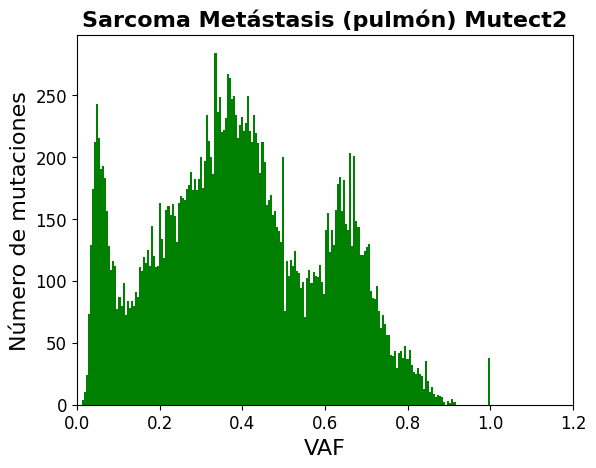

In [19]:
# Represent VAF from mutect2 table

plt.hist(vaf_mutect_df['VAF'].tolist(), bins = 200, color = 'green')
plt.xlim([0,1.2])
plt.ylabel('Número de mutaciones', fontsize=16)
plt.xlabel('VAF', fontsize=16)
plt.title('Sarcoma Metástasis (pulmón) Mutect2', fontsize=16, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('/workspace/projects/sjd_melos/exports_images/density_vaf_mutect_lung.png',dpi=300,transparent=True, format='png', bbox_inches='tight')
plt.show(vaf_mutect_df['VAF'].tolist())  

# 3/ WORKING WITH STRELKA FILES

In [20]:
# FOR THE SARCOMA-LUNG TUMOR SNVs and INDELS (strelka_snv_df and strelka_ind_df)
# First select mutations that passed filters
strelka_snv_df = strelka_snv_df[strelka_snv_df['FILTER'] == 'PASS']
strelka_ind_df = strelka_ind_df[strelka_ind_df['FILTER'] == 'PASS']

strelka_snv_df.rename(columns={'#CHROM': 'CHROM'}, inplace=True)
strelka_ind_df.rename(columns={'#CHROM': 'CHROM'}, inplace=True)

In [21]:
strelka_ind_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,TUMOR
479,chr1,4069973,.,T,TA,.,PASS,IC=13;IHP=19;MQ=60.00;MQ0=0;NT=ref;QSI=220;QSI...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"117:117:99,102:3,4:15,13:113.07:2.98:0.00:0.02","102:102:35,35:60,62:6,6:98.93:2.64:0.00:0.02"
598,chr1,4788541,.,T,TG,.,PASS,IC=2;IHP=2;MQ=60.00;MQ0=0;NT=ref;QSI=402;QSI_N...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"133:133:132,132:0,0:1,1:132.27:0.00:0.00:0.00","101:101:27,27:72,73:2,2:100.06:0.09:0.00:0.00"
1980,chr1,10715871,.,CG,C,.,PASS,IC=1;IHP=4;MQ=50.66;MQ0=5;NT=ref;QSI=44;QSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"65:65:37,51:4,7:24,13:61.99:21.69:0.00:0.34","25:25:3,5:10,16:13,15:29.22:12.33:0.00:0.41"
3441,chr1,19060349,.,C,CCA,.,PASS,IC=1;IHP=7;MQ=51.48;MQ0=0;NT=ref;QSI=3;QSI_NT=...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"29:29:8,15:0,2:21,16:27.53:17.57:0.00:0.63","17:17:4,9:4,6:10,7:16.92:11.42:0.00:0.69"
3628,chr1,20130828,.,CT,C,.,PASS,IC=10;IHP=15;MQ=59.84;MQ0=0;NT=ref;QSI=285;QSI...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"141:141:127,130:1,1:14,12:139.45:4.18:0.00:0.03","103:103:33,35:59,60:11,9:107.47:4.08:0.00:0.04"


### A. FOR THE INDELS SAMPLE

In [22]:
# Check the header information of the VCF file to find depth and allele frequency and in strelka manual in github or paper (https://github.com/Illumina/strelka/blob/v2.9.x/docs/userGuide/README.md; https://academic.oup.com/bioinformatics/article/28/14/1811/218573)

# 1/ Split tumor info from columns using ":" separator and add in new columns
strelka_ind_df = pd.concat([strelka_ind_df, strelka_ind_df['TUMOR'].str.split(':', expand=True)], axis=1)

# 2/ Rename new columns according to FORMAT column in original data 
strelka_ind_df = strelka_ind_df.rename(columns={0:'t_DP', 1: 't_DP2', 2:'t_TAR', 3: 't_TIR', 4: 't_TOR', 5:'t_DP50', 6:'t_FDP50', 7:'t_SUBDP50', 8: 't_BCN50'})
strelka_ind_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,TUMOR,t_DP,t_DP2,t_TAR,t_TIR,t_TOR,t_DP50,t_FDP50,t_SUBDP50,t_BCN50
479,chr1,4069973,.,T,TA,.,PASS,IC=13;IHP=19;MQ=60.00;MQ0=0;NT=ref;QSI=220;QSI...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"117:117:99,102:3,4:15,13:113.07:2.98:0.00:0.02","102:102:35,35:60,62:6,6:98.93:2.64:0.00:0.02",102,102,"35,35","60,62","6,6",98.93,2.64,0.00,0.02
598,chr1,4788541,.,T,TG,.,PASS,IC=2;IHP=2;MQ=60.00;MQ0=0;NT=ref;QSI=402;QSI_N...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"133:133:132,132:0,0:1,1:132.27:0.00:0.00:0.00","101:101:27,27:72,73:2,2:100.06:0.09:0.00:0.00",101,101,"27,27","72,73","2,2",100.06,0.09,0.00,0.00
1980,chr1,10715871,.,CG,C,.,PASS,IC=1;IHP=4;MQ=50.66;MQ0=5;NT=ref;QSI=44;QSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"65:65:37,51:4,7:24,13:61.99:21.69:0.00:0.34","25:25:3,5:10,16:13,15:29.22:12.33:0.00:0.41",25,25,"3,5","10,16","13,15",29.22,12.33,0.00,0.41
3441,chr1,19060349,.,C,CCA,.,PASS,IC=1;IHP=7;MQ=51.48;MQ0=0;NT=ref;QSI=3;QSI_NT=...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"29:29:8,15:0,2:21,16:27.53:17.57:0.00:0.63","17:17:4,9:4,6:10,7:16.92:11.42:0.00:0.69",17,17,"4,9","4,6","10,7",16.92,11.42,0.00,0.69
3628,chr1,20130828,.,CT,C,.,PASS,IC=10;IHP=15;MQ=59.84;MQ0=0;NT=ref;QSI=285;QSI...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"141:141:127,130:1,1:14,12:139.45:4.18:0.00:0.03","103:103:33,35:59,60:11,9:107.47:4.08:0.00:0.04",103,103,"33,35","59,60","11,9",107.47,4.08,0.00,0.04


In [23]:
# Now repeat 1/ and 2/ steps for the normal sample 
strelka_ind_df = pd.concat([strelka_ind_df, strelka_ind_df['NORMAL'].str.split(':', expand=True)], axis=1)
strelka_ind_df = strelka_ind_df.rename(columns={0:'n_DP', 1: 'n_DP2', 2:'n_TAR', 3: 'n_TIR', 4: 'n_TOR', 5:'n_DP50', 6:'n_FDP50', 7:'n_SUBDP50', 8: 'n_BCN50'})
strelka_ind_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,t_BCN50,n_DP,n_DP2,n_TAR,n_TIR,n_TOR,n_DP50,n_FDP50,n_SUBDP50,n_BCN50
479,chr1,4069973,.,T,TA,.,PASS,IC=13;IHP=19;MQ=60.00;MQ0=0;NT=ref;QSI=220;QSI...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"117:117:99,102:3,4:15,13:113.07:2.98:0.00:0.02",...,0.02,117,117,"99,102","3,4","15,13",113.07,2.98,0.00,0.02
598,chr1,4788541,.,T,TG,.,PASS,IC=2;IHP=2;MQ=60.00;MQ0=0;NT=ref;QSI=402;QSI_N...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"133:133:132,132:0,0:1,1:132.27:0.00:0.00:0.00",...,0.00,133,133,"132,132","0,0","1,1",132.27,0.00,0.00,0.00
1980,chr1,10715871,.,CG,C,.,PASS,IC=1;IHP=4;MQ=50.66;MQ0=5;NT=ref;QSI=44;QSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"65:65:37,51:4,7:24,13:61.99:21.69:0.00:0.34",...,0.41,65,65,"37,51","4,7","24,13",61.99,21.69,0.00,0.34
3441,chr1,19060349,.,C,CCA,.,PASS,IC=1;IHP=7;MQ=51.48;MQ0=0;NT=ref;QSI=3;QSI_NT=...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"29:29:8,15:0,2:21,16:27.53:17.57:0.00:0.63",...,0.69,29,29,"8,15","0,2","21,16",27.53,17.57,0.00,0.63
3628,chr1,20130828,.,CT,C,.,PASS,IC=10;IHP=15;MQ=59.84;MQ0=0;NT=ref;QSI=285;QSI...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"141:141:127,130:1,1:14,12:139.45:4.18:0.00:0.03",...,0.04,141,141,"127,130","1,1","14,12",139.45,4.18,0.00,0.03


In [24]:
# Delete unnecessary information
strelka_ind_df = strelka_ind_df.drop(columns=['n_DP2','t_DP2','n_TOR','t_TOR','n_DP50','t_DP50','n_FDP50','t_FDP50','n_SUBDP50','t_SUBDP50','n_BCN50','t_BCN50'])

# Add sample name and mutation type
strelka_ind_df = strelka_ind_df.assign(SAMPLE='sarcoma_lung')
strelka_ind_df = strelka_ind_df.assign(Mut_type='INDEL')
strelka_ind_df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,TUMOR,t_DP,t_TAR,t_TIR,n_DP,n_TAR,n_TIR,SAMPLE,Mut_type
479,chr1,4069973,.,T,TA,.,PASS,IC=13;IHP=19;MQ=60.00;MQ0=0;NT=ref;QSI=220;QSI...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"117:117:99,102:3,4:15,13:113.07:2.98:0.00:0.02","102:102:35,35:60,62:6,6:98.93:2.64:0.00:0.02",102,"35,35","60,62",117,"99,102","3,4",sarcoma_lung,INDEL
598,chr1,4788541,.,T,TG,.,PASS,IC=2;IHP=2;MQ=60.00;MQ0=0;NT=ref;QSI=402;QSI_N...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"133:133:132,132:0,0:1,1:132.27:0.00:0.00:0.00","101:101:27,27:72,73:2,2:100.06:0.09:0.00:0.00",101,"27,27","72,73",133,"132,132","0,0",sarcoma_lung,INDEL
1980,chr1,10715871,.,CG,C,.,PASS,IC=1;IHP=4;MQ=50.66;MQ0=5;NT=ref;QSI=44;QSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"65:65:37,51:4,7:24,13:61.99:21.69:0.00:0.34","25:25:3,5:10,16:13,15:29.22:12.33:0.00:0.41",25,"3,5","10,16",65,"37,51","4,7",sarcoma_lung,INDEL
3441,chr1,19060349,.,C,CCA,.,PASS,IC=1;IHP=7;MQ=51.48;MQ0=0;NT=ref;QSI=3;QSI_NT=...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"29:29:8,15:0,2:21,16:27.53:17.57:0.00:0.63","17:17:4,9:4,6:10,7:16.92:11.42:0.00:0.69",17,"4,9","4,6",29,"8,15","0,2",sarcoma_lung,INDEL
3628,chr1,20130828,.,CT,C,.,PASS,IC=10;IHP=15;MQ=59.84;MQ0=0;NT=ref;QSI=285;QSI...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"141:141:127,130:1,1:14,12:139.45:4.18:0.00:0.03","103:103:33,35:59,60:11,9:107.47:4.08:0.00:0.04",103,"33,35","59,60",141,"127,130","1,1",sarcoma_lung,INDEL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189326,chrY,13880669,.,AG,A,.,PASS,IC=1;IHP=6;MQ=60.00;MQ0=0;NT=ref;QSI=198;QSI_N...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"75:75:72,72:0,0:2,2:72.86:0.00:0.00:0.00","50:50:15,15:32,32:4,4:53.27:0.00:0.00:0.00",50,"15,15","32,32",75,"72,72","0,0",sarcoma_lung,INDEL
189332,chrY,16242326,.,GAAAGAA,G,.,PASS,IC=0;IHP=6;MQ=38.95;MQ0=4;NT=ref;QSI=62;QSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"67:67:73,88:0,0:0,10:53.40:7.92:0.00:0.13","40:40:36,52:5,7:2,7:33.56:5.83:0.00:0.15",40,"36,52","5,7",67,"73,88","0,0",sarcoma_lung,INDEL
189333,chrY,16426090,.,TA,T,.,PASS,IC=3;IHP=5;MQ=60.00;MQ0=0;NT=ref;QSI=129;QSI_N...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"49:49:48,49:0,0:1,0:52.97:0.36:0.00:0.00","59:59:18,18:38,38:3,3:56.33:0.00:0.00:0.00",59,"18,18","38,38",49,"48,49","0,0",sarcoma_lung,INDEL
189335,chrY,16962796,.,AC,A,.,PASS,IC=0;IHP=3;MQ=60.00;MQ0=0;NT=ref;QSI=165;QSI_N...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"65:65:65,67:0,0:0,0:63.44:0.54:0.00:0.00","60:60:23,23:31,32:6,6:54.91:0.00:0.00:0.00",60,"23,23","31,32",65,"65,67","0,0",sarcoma_lung,INDEL


In [25]:
# saving this table as a tsv compressed file in directory project

# strelka_ind_df.to_csv('/workspace/projects/sjd_melos/MAFs_tables/Lung_Strelka_indels_passedmut.tsv.gz', sep ='\t', index=None, compression = "gzip")

In [26]:
# From tumor information split allele reads from reference or alternate allele into tier1 and tier2 comma separated values
vaf_strelka_ind_df = strelka_ind_df.copy() #create a new variable from previous tab
vaf_strelka_ind_df[['t_TIR_tier1', 't_TIR_tier2']] = vaf_strelka_ind_df['t_TIR'].str.split(',', expand=True)
vaf_strelka_ind_df[['t_TAR_tier1', 't_TAR_tier2']] = vaf_strelka_ind_df['t_TAR'].str.split(',', expand=True)
vaf_strelka_ind_df = vaf_strelka_ind_df.drop(['t_TIR','t_TAR'], axis=1) # delete original column

# Now from normal sample split allele reads from reference or alternate allele into tier1 and tier2 comma separated values
vaf_strelka_ind_df[['n_TIR_tier1', 'n_TIR_tier2']] = vaf_strelka_ind_df['n_TIR'].str.split(',', expand=True)
vaf_strelka_ind_df[['n_TAR_tier1', 'n_TAR_tier2']] = vaf_strelka_ind_df['n_TAR'].str.split(',', expand=True)
vaf_strelka_ind_df = vaf_strelka_ind_df.drop(['n_TIR','n_TAR'], axis=1) # delete original column

In [27]:
vaf_strelka_ind_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,SAMPLE,Mut_type,t_TIR_tier1,t_TIR_tier2,t_TAR_tier1,t_TAR_tier2,n_TIR_tier1,n_TIR_tier2,n_TAR_tier1,n_TAR_tier2
479,chr1,4069973,.,T,TA,.,PASS,IC=13;IHP=19;MQ=60.00;MQ0=0;NT=ref;QSI=220;QSI...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"117:117:99,102:3,4:15,13:113.07:2.98:0.00:0.02",...,sarcoma_lung,INDEL,60,62,35,35,3,4,99,102
598,chr1,4788541,.,T,TG,.,PASS,IC=2;IHP=2;MQ=60.00;MQ0=0;NT=ref;QSI=402;QSI_N...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"133:133:132,132:0,0:1,1:132.27:0.00:0.00:0.00",...,sarcoma_lung,INDEL,72,73,27,27,0,0,132,132
1980,chr1,10715871,.,CG,C,.,PASS,IC=1;IHP=4;MQ=50.66;MQ0=5;NT=ref;QSI=44;QSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"65:65:37,51:4,7:24,13:61.99:21.69:0.00:0.34",...,sarcoma_lung,INDEL,10,16,3,5,4,7,37,51
3441,chr1,19060349,.,C,CCA,.,PASS,IC=1;IHP=7;MQ=51.48;MQ0=0;NT=ref;QSI=3;QSI_NT=...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"29:29:8,15:0,2:21,16:27.53:17.57:0.00:0.63",...,sarcoma_lung,INDEL,4,6,4,9,0,2,8,15
3628,chr1,20130828,.,CT,C,.,PASS,IC=10;IHP=15;MQ=59.84;MQ0=0;NT=ref;QSI=285;QSI...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"141:141:127,130:1,1:14,12:139.45:4.18:0.00:0.03",...,sarcoma_lung,INDEL,59,60,33,35,1,1,127,130


In [28]:
#Transform columns so they are not strings but operable
vaf_strelka_ind_df[['t_DP', 't_TIR_tier1']] = vaf_strelka_ind_df[['t_DP', 't_TIR_tier1']].astype(int)

# Calculation of VAF in tumor sample
vaf_strelka_ind_df['VAF'] = vaf_strelka_ind_df['t_TIR_tier1'] / vaf_strelka_ind_df['t_DP']  # obtain the VAF frequency of each allele
vaf_strelka_ind_df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,Mut_type,t_TIR_tier1,t_TIR_tier2,t_TAR_tier1,t_TAR_tier2,n_TIR_tier1,n_TIR_tier2,n_TAR_tier1,n_TAR_tier2,VAF
479,chr1,4069973,.,T,TA,.,PASS,IC=13;IHP=19;MQ=60.00;MQ0=0;NT=ref;QSI=220;QSI...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"117:117:99,102:3,4:15,13:113.07:2.98:0.00:0.02",...,INDEL,60,62,35,35,3,4,99,102,0.588235
598,chr1,4788541,.,T,TG,.,PASS,IC=2;IHP=2;MQ=60.00;MQ0=0;NT=ref;QSI=402;QSI_N...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"133:133:132,132:0,0:1,1:132.27:0.00:0.00:0.00",...,INDEL,72,73,27,27,0,0,132,132,0.712871
1980,chr1,10715871,.,CG,C,.,PASS,IC=1;IHP=4;MQ=50.66;MQ0=5;NT=ref;QSI=44;QSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"65:65:37,51:4,7:24,13:61.99:21.69:0.00:0.34",...,INDEL,10,16,3,5,4,7,37,51,0.400000
3441,chr1,19060349,.,C,CCA,.,PASS,IC=1;IHP=7;MQ=51.48;MQ0=0;NT=ref;QSI=3;QSI_NT=...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"29:29:8,15:0,2:21,16:27.53:17.57:0.00:0.63",...,INDEL,4,6,4,9,0,2,8,15,0.235294
3628,chr1,20130828,.,CT,C,.,PASS,IC=10;IHP=15;MQ=59.84;MQ0=0;NT=ref;QSI=285;QSI...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"141:141:127,130:1,1:14,12:139.45:4.18:0.00:0.03",...,INDEL,59,60,33,35,1,1,127,130,0.572816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189326,chrY,13880669,.,AG,A,.,PASS,IC=1;IHP=6;MQ=60.00;MQ0=0;NT=ref;QSI=198;QSI_N...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"75:75:72,72:0,0:2,2:72.86:0.00:0.00:0.00",...,INDEL,32,32,15,15,0,0,72,72,0.640000
189332,chrY,16242326,.,GAAAGAA,G,.,PASS,IC=0;IHP=6;MQ=38.95;MQ0=4;NT=ref;QSI=62;QSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"67:67:73,88:0,0:0,10:53.40:7.92:0.00:0.13",...,INDEL,5,7,36,52,0,0,73,88,0.125000
189333,chrY,16426090,.,TA,T,.,PASS,IC=3;IHP=5;MQ=60.00;MQ0=0;NT=ref;QSI=129;QSI_N...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"49:49:48,49:0,0:1,0:52.97:0.36:0.00:0.00",...,INDEL,38,38,18,18,0,0,48,49,0.644068
189335,chrY,16962796,.,AC,A,.,PASS,IC=0;IHP=3;MQ=60.00;MQ0=0;NT=ref;QSI=165;QSI_N...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"65:65:65,67:0,0:0,0:63.44:0.54:0.00:0.00",...,INDEL,31,32,23,23,0,0,65,67,0.516667


In [29]:
# Rename columns
vaf_strelka_ind_df.rename(columns={'t_TIR_tier1': 't_alt_reads','n_TIR_tier1':'n_alt_reads','t_TAR_tier1':'t_ref_reads','n_TAR_tier1':'n_ref_reads'}, inplace=True)

# Drop unnecessary columns:
vaf_strelka_ind_df = vaf_strelka_ind_df.drop(['t_TIR_tier2','t_TAR_tier2','n_TIR_tier2','n_TAR_tier2'], axis=1) # delete original column

In [30]:
# First check column information:
for col in vaf_strelka_ind_df.columns:
    print(col)

CHROM
POS
ID
REF
ALT
QUAL
FILTER
INFO
FORMAT
NORMAL
TUMOR
t_DP
n_DP
SAMPLE
Mut_type
t_alt_reads
t_ref_reads
n_alt_reads
n_ref_reads
VAF


In [31]:
# Then reorganize columns
vaf_strelka_ind_df.insert(19, 'SAMPLE', vaf_strelka_ind_df.pop('SAMPLE'))
vaf_strelka_ind_df.insert(18, 'Mut_type', vaf_strelka_ind_df.pop('Mut_type'))
vaf_strelka_ind_df.insert(18, 'Mut_type', vaf_strelka_ind_df.pop('Mut_type'))
vaf_strelka_ind_df.insert(13, 't_ref_reads', vaf_strelka_ind_df.pop('t_ref_reads'))
vaf_strelka_ind_df.insert(14, 'n_ref_reads', vaf_strelka_ind_df.pop('n_ref_reads'))

for col in vaf_strelka_ind_df.columns:
    print(col)

CHROM
POS
ID
REF
ALT
QUAL
FILTER
INFO
FORMAT
NORMAL
TUMOR
t_DP
n_DP
t_ref_reads
n_ref_reads
t_alt_reads
n_alt_reads
VAF
Mut_type
SAMPLE


In [32]:
vaf_strelka_ind_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,TUMOR,t_DP,n_DP,t_ref_reads,n_ref_reads,t_alt_reads,n_alt_reads,VAF,Mut_type,SAMPLE
479,chr1,4069973,.,T,TA,.,PASS,IC=13;IHP=19;MQ=60.00;MQ0=0;NT=ref;QSI=220;QSI...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"117:117:99,102:3,4:15,13:113.07:2.98:0.00:0.02","102:102:35,35:60,62:6,6:98.93:2.64:0.00:0.02",102,117,35,99,60,3,0.588235,INDEL,sarcoma_lung
598,chr1,4788541,.,T,TG,.,PASS,IC=2;IHP=2;MQ=60.00;MQ0=0;NT=ref;QSI=402;QSI_N...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"133:133:132,132:0,0:1,1:132.27:0.00:0.00:0.00","101:101:27,27:72,73:2,2:100.06:0.09:0.00:0.00",101,133,27,132,72,0,0.712871,INDEL,sarcoma_lung
1980,chr1,10715871,.,CG,C,.,PASS,IC=1;IHP=4;MQ=50.66;MQ0=5;NT=ref;QSI=44;QSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"65:65:37,51:4,7:24,13:61.99:21.69:0.00:0.34","25:25:3,5:10,16:13,15:29.22:12.33:0.00:0.41",25,65,3,37,10,4,0.400000,INDEL,sarcoma_lung
3441,chr1,19060349,.,C,CCA,.,PASS,IC=1;IHP=7;MQ=51.48;MQ0=0;NT=ref;QSI=3;QSI_NT=...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"29:29:8,15:0,2:21,16:27.53:17.57:0.00:0.63","17:17:4,9:4,6:10,7:16.92:11.42:0.00:0.69",17,29,4,8,4,0,0.235294,INDEL,sarcoma_lung
3628,chr1,20130828,.,CT,C,.,PASS,IC=10;IHP=15;MQ=59.84;MQ0=0;NT=ref;QSI=285;QSI...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"141:141:127,130:1,1:14,12:139.45:4.18:0.00:0.03","103:103:33,35:59,60:11,9:107.47:4.08:0.00:0.04",103,141,33,127,59,1,0.572816,INDEL,sarcoma_lung


In [33]:
# Save in a new file with passed mutations
# vaf_strelka_ind_df.to_csv('/workspace/projects/sjd_melos/MAFs_tables/Lung_Strelka_indels_VAF.tsv.gz', sep ='\t', index=None, compression = "gzip")

### B. FOR THE SNV SAMPLE

In [34]:
# Check the header information of the VCF file to find this information and strelka manual in github or paper (https://github.com/Illumina/strelka/blob/v2.9.x/docs/userGuide/README.md; https://academic.oup.com/bioinformatics/article/28/14/1811/218573)

# 1/ Split TUMOR info from column using ":" separator and add in new columns
strelka_snv_df = pd.concat([strelka_snv_df, strelka_snv_df['TUMOR'].str.split(':', expand=True)], axis=1)

# 2/ Rename new columns according to FORMAT column in original data 
strelka_snv_df = strelka_snv_df.rename(columns={0:'t_DP', 1: 't_FDP', 2:'t_SDP', 3: 't_SUBDP', 4: 't_AU', 5:'t_CU', 6:'t_GU', 7:'t_TU'})
strelka_snv_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,TUMOR,t_DP,t_FDP,t_SDP,t_SUBDP,t_AU,t_CU,t_GU,t_TU
11,chr1,14843,.,G,T,.,PASS,DP=528;MQ=16.50;MQ0=290;NT=ref;QSS=39;QSS_NT=3...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"127:1:0:0:0,0:0,0:103,267:23,37","20:0:0:0:0,0:0,0:6,161:14,63",20,0,0,0,"0,0","0,0","6,161","14,63"
59,chr1,104188,.,C,A,.,PASS,DP=554;MQ=30.34;MQ0=132;NT=ref;QSS=267;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"133:4:0:0:0,0:129,283:0,0:0,0","115:3:0:0:52,60:59,206:0,1:1,4",115,3,0,0,"52,60","59,206","0,1","1,4"
159,chr1,633887,.,G,A,.,PASS,DP=560;MQ=32.55;MQ0=144;NT=ref;QSS=210;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"126:0:0:0:11,36:0,0:115,115:0,0","103:1:0:0:66,372:1,1:35,35:0,1",103,1,0,0,"66,372","1,1","35,35","0,1"
248,chr1,843320,.,G,A,.,PASS,DP=235;MQ=59.89;MQ0=0;NT=ref;QSS=419;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"126:0:0:0:0,0:0,0:126,127:0,0","108:2:0:0:80,81:0,0:26,27:0,0",108,2,0,0,"80,81","0,0","26,27","0,0"
649,chr1,1118520,.,C,T,.,PASS,DP=291;MQ=60.00;MQ0=0;NT=ref;QSS=210;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"155:1:0:0:0,0:154,155:0,0:0,0","136:0:0:0:0,0:94,94:0,0:42,42",136,0,0,0,"0,0","94,94","0,0","42,42"


In [35]:
# Now repeat 1/ and 2/ steps for the normal sample 
strelka_snv_df = pd.concat([strelka_snv_df, strelka_snv_df['NORMAL'].str.split(':', expand=True)], axis=1)
strelka_snv_df = strelka_snv_df.rename(columns={0:'n_DP', 1: 'n_FDP', 2:'n_SDP', 3: 'n_SUBDP', 4: 'n_AU', 5:'n_CU', 6:'n_GU', 7:'n_TU'})
strelka_snv_df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,t_GU,t_TU,n_DP,n_FDP,n_SDP,n_SUBDP,n_AU,n_CU,n_GU,n_TU
11,chr1,14843,.,G,T,.,PASS,DP=528;MQ=16.50;MQ0=290;NT=ref;QSS=39;QSS_NT=3...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"127:1:0:0:0,0:0,0:103,267:23,37",...,"6,161","14,63",127,1,0,0,"0,0","0,0","103,267","23,37"
59,chr1,104188,.,C,A,.,PASS,DP=554;MQ=30.34;MQ0=132;NT=ref;QSS=267;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"133:4:0:0:0,0:129,283:0,0:0,0",...,"0,1","1,4",133,4,0,0,"0,0","129,283","0,0","0,0"
159,chr1,633887,.,G,A,.,PASS,DP=560;MQ=32.55;MQ0=144;NT=ref;QSS=210;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"126:0:0:0:11,36:0,0:115,115:0,0",...,"35,35","0,1",126,0,0,0,"11,36","0,0","115,115","0,0"
248,chr1,843320,.,G,A,.,PASS,DP=235;MQ=59.89;MQ0=0;NT=ref;QSS=419;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"126:0:0:0:0,0:0,0:126,127:0,0",...,"26,27","0,0",126,0,0,0,"0,0","0,0","126,127","0,0"
649,chr1,1118520,.,C,T,.,PASS,DP=291;MQ=60.00;MQ0=0;NT=ref;QSS=210;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"155:1:0:0:0,0:154,155:0,0:0,0",...,"0,0","42,42",155,1,0,0,"0,0","154,155","0,0","0,0"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1438642,chrY,26659702,.,A,T,.,PASS,DP=2698;MQ=22.55;MQ0=602;NT=ref;QSS=331;QSS_NT...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"438:57:0:0:380,1287:0,2:0,0:1,11",...,"0,0","87,408",438,57,0,0,"380,1287","0,2","0,0","1,11"
1438760,chrY,56828925,.,A,G,.,PASS,DP=2402;MQ=43.61;MQ0=292;NT=ref;QSS=396;QSS_NT...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"583:93:8:0:489,1047:0,1:1,38:0,5",...,"107,337","0,29",583,93,8,0,"489,1047","0,1","1,38","0,5"
1438851,chrY,56842066,.,C,A,.,PASS,DP=516;MQ=59.60;MQ0=0;NT=ref;QSS=353;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"302:1:0:0:1,1:300,305:0,0:0,0",...,"0,0","0,0",302,1,0,0,"1,1","300,305","0,0","0,0"
1438852,chrY,56842067,.,T,C,.,PASS,DP=518;MQ=59.60;MQ0=0;NT=ref;QSS=354;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"304:1:0:0:1,1:0,0:0,0:302,307",...,"1,1","137,140",304,1,0,0,"1,1","0,0","0,0","302,307"


In [36]:
# First check column information:
for col in strelka_snv_df.columns:
    print(col)

CHROM
POS
ID
REF
ALT
QUAL
FILTER
INFO
FORMAT
NORMAL
TUMOR
t_DP
t_FDP
t_SDP
t_SUBDP
t_AU
t_CU
t_GU
t_TU
n_DP
n_FDP
n_SDP
n_SUBDP
n_AU
n_CU
n_GU
n_TU


In [37]:
# Delete unnecessary information
strelka_snv_df = strelka_snv_df.drop(columns=['n_FDP','n_SDP','n_SUBDP','t_FDP','t_SDP','t_SUBDP'])
strelka_snv_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,t_DP,t_AU,t_CU,t_GU,t_TU,n_DP,n_AU,n_CU,n_GU,n_TU
11,chr1,14843,.,G,T,.,PASS,DP=528;MQ=16.50;MQ0=290;NT=ref;QSS=39;QSS_NT=3...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"127:1:0:0:0,0:0,0:103,267:23,37",...,20,"0,0","0,0","6,161","14,63",127,"0,0","0,0","103,267","23,37"
59,chr1,104188,.,C,A,.,PASS,DP=554;MQ=30.34;MQ0=132;NT=ref;QSS=267;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"133:4:0:0:0,0:129,283:0,0:0,0",...,115,"52,60","59,206","0,1","1,4",133,"0,0","129,283","0,0","0,0"
159,chr1,633887,.,G,A,.,PASS,DP=560;MQ=32.55;MQ0=144;NT=ref;QSS=210;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"126:0:0:0:11,36:0,0:115,115:0,0",...,103,"66,372","1,1","35,35","0,1",126,"11,36","0,0","115,115","0,0"
248,chr1,843320,.,G,A,.,PASS,DP=235;MQ=59.89;MQ0=0;NT=ref;QSS=419;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"126:0:0:0:0,0:0,0:126,127:0,0",...,108,"80,81","0,0","26,27","0,0",126,"0,0","0,0","126,127","0,0"
649,chr1,1118520,.,C,T,.,PASS,DP=291;MQ=60.00;MQ0=0;NT=ref;QSS=210;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"155:1:0:0:0,0:154,155:0,0:0,0",...,136,"0,0","94,94","0,0","42,42",155,"0,0","154,155","0,0","0,0"


In [38]:
# Add sample name and mutation type
strelka_snv_df = strelka_snv_df.assign(SAMPLE='sarcoma_lung')
strelka_snv_df = strelka_snv_df.assign(Mut_type='SNV')
strelka_snv_df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,t_CU,t_GU,t_TU,n_DP,n_AU,n_CU,n_GU,n_TU,SAMPLE,Mut_type
11,chr1,14843,.,G,T,.,PASS,DP=528;MQ=16.50;MQ0=290;NT=ref;QSS=39;QSS_NT=3...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"127:1:0:0:0,0:0,0:103,267:23,37",...,"0,0","6,161","14,63",127,"0,0","0,0","103,267","23,37",sarcoma_lung,SNV
59,chr1,104188,.,C,A,.,PASS,DP=554;MQ=30.34;MQ0=132;NT=ref;QSS=267;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"133:4:0:0:0,0:129,283:0,0:0,0",...,"59,206","0,1","1,4",133,"0,0","129,283","0,0","0,0",sarcoma_lung,SNV
159,chr1,633887,.,G,A,.,PASS,DP=560;MQ=32.55;MQ0=144;NT=ref;QSS=210;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"126:0:0:0:11,36:0,0:115,115:0,0",...,"1,1","35,35","0,1",126,"11,36","0,0","115,115","0,0",sarcoma_lung,SNV
248,chr1,843320,.,G,A,.,PASS,DP=235;MQ=59.89;MQ0=0;NT=ref;QSS=419;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"126:0:0:0:0,0:0,0:126,127:0,0",...,"0,0","26,27","0,0",126,"0,0","0,0","126,127","0,0",sarcoma_lung,SNV
649,chr1,1118520,.,C,T,.,PASS,DP=291;MQ=60.00;MQ0=0;NT=ref;QSS=210;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"155:1:0:0:0,0:154,155:0,0:0,0",...,"94,94","0,0","42,42",155,"0,0","154,155","0,0","0,0",sarcoma_lung,SNV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1438642,chrY,26659702,.,A,T,.,PASS,DP=2698;MQ=22.55;MQ0=602;NT=ref;QSS=331;QSS_NT...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"438:57:0:0:380,1287:0,2:0,0:1,11",...,"0,3","0,0","87,408",438,"380,1287","0,2","0,0","1,11",sarcoma_lung,SNV
1438760,chrY,56828925,.,A,G,.,PASS,DP=2402;MQ=43.61;MQ0=292;NT=ref;QSS=396;QSS_NT...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"583:93:8:0:489,1047:0,1:1,38:0,5",...,"1,4","107,337","0,29",583,"489,1047","0,1","1,38","0,5",sarcoma_lung,SNV
1438851,chrY,56842066,.,C,A,.,PASS,DP=516;MQ=59.60;MQ0=0;NT=ref;QSS=353;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"302:1:0:0:1,1:300,305:0,0:0,0",...,"137,140","0,0","0,0",302,"1,1","300,305","0,0","0,0",sarcoma_lung,SNV
1438852,chrY,56842067,.,T,C,.,PASS,DP=518;MQ=59.60;MQ0=0;NT=ref;QSS=354;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"304:1:0:0:1,1:0,0:0,0:302,307",...,"68,69","1,1","137,140",304,"1,1","0,0","0,0","302,307",sarcoma_lung,SNV


In [39]:
#saving this table a CSV file in directory project
# strelka_snv_df.to_csv('/workspace/projects/sjd_melos/MAFs_tables/Lung_Strelka_SNV_passedmut.tsv.gz', sep ='\t', index=None, compression = "gzip")

In [40]:
# Split information to calculate VAF from sample
vaf_strelka_snv_df = strelka_snv_df.copy() 

# Split allele depth frequency column information so it contains tier1 or tier2 allele depth information
vaf_strelka_snv_df[['t_A_tier1', 't_A_tier2']] = vaf_strelka_snv_df['t_AU'].str.split(',', expand=True)
vaf_strelka_snv_df = vaf_strelka_snv_df.drop(['t_AU'], axis=1) # delete original column
vaf_strelka_snv_df[['t_C_tier1', 't_C_tier2']] = vaf_strelka_snv_df['t_CU'].str.split(',', expand=True)
vaf_strelka_snv_df = vaf_strelka_snv_df.drop(['t_CU'], axis=1) # delete original column
vaf_strelka_snv_df[['t_G_tier1', 't_G_tier2']] = vaf_strelka_snv_df['t_GU'].str.split(',', expand=True)
vaf_strelka_snv_df = vaf_strelka_snv_df.drop(['t_GU'], axis=1) # delete original column
vaf_strelka_snv_df[['t_T_tier1', 't_T_tier2']] = vaf_strelka_snv_df['t_TU'].str.split(',', expand=True)
vaf_strelka_snv_df = vaf_strelka_snv_df.drop(['t_TU'], axis=1) # delete original column

In [41]:
# Now the same for normal sample: split allele depth frequency column information so it contains tier1 or tier2 allele depth information
vaf_strelka_snv_df[['n_A_tier1', 'n_A_tier2']] = vaf_strelka_snv_df['n_AU'].str.split(',', expand=True)
vaf_strelka_snv_df = vaf_strelka_snv_df.drop(['n_AU'], axis=1) # delete original column
vaf_strelka_snv_df[['n_C_tier1', 'n_C_tier2']] = vaf_strelka_snv_df['n_CU'].str.split(',', expand=True)
vaf_strelka_snv_df = vaf_strelka_snv_df.drop(['n_CU'], axis=1) # delete original column
vaf_strelka_snv_df[['n_G_tier1', 'n_G_tier2']] = vaf_strelka_snv_df['n_GU'].str.split(',', expand=True)
vaf_strelka_snv_df = vaf_strelka_snv_df.drop(['n_GU'], axis=1) # delete original column
vaf_strelka_snv_df[['n_T_tier1', 'n_T_tier2']] = vaf_strelka_snv_df['n_TU'].str.split(',', expand=True)
vaf_strelka_snv_df = vaf_strelka_snv_df.drop(['n_TU'], axis=1) # delete original column

In [42]:
# Delete rows that contain tier2 that is unnecessary for the next steps
vaf_strelka_snv_df = vaf_strelka_snv_df.drop(['t_A_tier2', 'n_A_tier2','t_C_tier2','n_C_tier2','t_G_tier2', 'n_G_tier2', 't_T_tier2', 'n_T_tier2'], axis=1)

#Transform columns so they are not strings but operable with pd function to_numeric
vaf_strelka_snv_df = pd.DataFrame(vaf_strelka_snv_df)
vaf_strelka_snv_df[['t_DP', 't_A_tier1', 't_C_tier1', 't_G_tier1', 't_T_tier1']] = vaf_strelka_snv_df[['t_DP', 't_A_tier1', 't_C_tier1','t_G_tier1','t_T_tier1']].apply(pd.to_numeric)

In [43]:
vaf_strelka_snv_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,SAMPLE,Mut_type,t_A_tier1,t_C_tier1,t_G_tier1,t_T_tier1,n_A_tier1,n_C_tier1,n_G_tier1,n_T_tier1
11,chr1,14843,.,G,T,.,PASS,DP=528;MQ=16.50;MQ0=290;NT=ref;QSS=39;QSS_NT=3...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"127:1:0:0:0,0:0,0:103,267:23,37",...,sarcoma_lung,SNV,0,0,6,14,0,0,103,23
59,chr1,104188,.,C,A,.,PASS,DP=554;MQ=30.34;MQ0=132;NT=ref;QSS=267;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"133:4:0:0:0,0:129,283:0,0:0,0",...,sarcoma_lung,SNV,52,59,0,1,0,129,0,0
159,chr1,633887,.,G,A,.,PASS,DP=560;MQ=32.55;MQ0=144;NT=ref;QSS=210;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"126:0:0:0:11,36:0,0:115,115:0,0",...,sarcoma_lung,SNV,66,1,35,0,11,0,115,0
248,chr1,843320,.,G,A,.,PASS,DP=235;MQ=59.89;MQ0=0;NT=ref;QSS=419;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"126:0:0:0:0,0:0,0:126,127:0,0",...,sarcoma_lung,SNV,80,0,26,0,0,0,126,0
649,chr1,1118520,.,C,T,.,PASS,DP=291;MQ=60.00;MQ0=0;NT=ref;QSS=210;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"155:1:0:0:0,0:154,155:0,0:0,0",...,sarcoma_lung,SNV,0,94,0,42,0,154,0,0


In [44]:
# First check column information:
for col in strelka_snv_df.columns:
    print(col)

CHROM
POS
ID
REF
ALT
QUAL
FILTER
INFO
FORMAT
NORMAL
TUMOR
t_DP
t_AU
t_CU
t_GU
t_TU
n_DP
n_AU
n_CU
n_GU
n_TU
SAMPLE
Mut_type


In [45]:
# Define a function that applies the value of 'X_tier1' column depending on the value on 'ALT' column for tumor sample
def get_allele_alt_tumor(row):
    alt = row['ALT']
    if alt == 'A':
        vaf_alt = row['t_A_tier1']
    elif alt == 'T':
        vaf_alt = row['t_T_tier1']
    elif alt == 'C':
        vaf_alt = row['t_C_tier1']
    else:
        vaf_alt = row['t_G_tier1']
    return vaf_alt


# Define a function that applies the value of 'X_tier1' column depending on the value on 'ALT' column for blood sample
def get_allele_alt_normal(row):
    alt = row['ALT']
    if alt == 'A':
        vaf_alt = row['n_A_tier1']
    elif alt == 'T':
        vaf_alt = row['n_T_tier1']
    elif alt == 'C':
        vaf_alt = row['n_C_tier1']
    else:
        vaf_alt = row['n_G_tier1']
    return vaf_alt


# Apply the function so it returns in each row the corresponding allele depth:
vaf_strelka_snv_df = vaf_strelka_snv_df.loc[0:]
vaf_strelka_snv_df['t_alt_reads'] = vaf_strelka_snv_df.apply(lambda row: get_allele_alt_tumor(row), axis =1) 
vaf_strelka_snv_df['n_alt_reads'] = vaf_strelka_snv_df.apply(lambda row: get_allele_alt_normal(row), axis =1)
vaf_strelka_snv_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,t_A_tier1,t_C_tier1,t_G_tier1,t_T_tier1,n_A_tier1,n_C_tier1,n_G_tier1,n_T_tier1,t_alt_reads,n_alt_reads
11,chr1,14843,.,G,T,.,PASS,DP=528;MQ=16.50;MQ0=290;NT=ref;QSS=39;QSS_NT=3...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"127:1:0:0:0,0:0,0:103,267:23,37",...,0,0,6,14,0,0,103,23,14,23
59,chr1,104188,.,C,A,.,PASS,DP=554;MQ=30.34;MQ0=132;NT=ref;QSS=267;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"133:4:0:0:0,0:129,283:0,0:0,0",...,52,59,0,1,0,129,0,0,52,0
159,chr1,633887,.,G,A,.,PASS,DP=560;MQ=32.55;MQ0=144;NT=ref;QSS=210;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"126:0:0:0:11,36:0,0:115,115:0,0",...,66,1,35,0,11,0,115,0,66,11
248,chr1,843320,.,G,A,.,PASS,DP=235;MQ=59.89;MQ0=0;NT=ref;QSS=419;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"126:0:0:0:0,0:0,0:126,127:0,0",...,80,0,26,0,0,0,126,0,80,0
649,chr1,1118520,.,C,T,.,PASS,DP=291;MQ=60.00;MQ0=0;NT=ref;QSS=210;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"155:1:0:0:0,0:154,155:0,0:0,0",...,0,94,0,42,0,154,0,0,42,0


In [46]:
# Define a function that applies the value of 'X_tier1' column depending on the value on 'REF' column for blood sample
def get_allele_ref_normal(row):
    ref = row['REF']
    if ref == 'A':
        vaf_ref = row['n_A_tier1']
    elif ref == 'T':
        vaf_ref = row['n_T_tier1']
    elif ref == 'C':
        vaf_ref = row['n_C_tier1']
    else:
        vaf_ref = row['n_G_tier1']
    return vaf_ref

# Define a function that applies the value of 'X_tier1' column depending on the value on 'REF' column for tumor sample
def get_allele_ref_tumor(row):
    ref = row['REF']
    if ref == 'A':
        vaf_ref = row['t_A_tier1']
    elif ref == 'T':
        vaf_ref = row['t_T_tier1']
    elif ref == 'C':
        vaf_ref = row['t_C_tier1']
    else:
        vaf_ref = row['t_G_tier1']
    return vaf_ref
    
# Apply the function so it returns in each row the corresponding allele depth:
vaf_strelka_snv_df = vaf_strelka_snv_df.loc[0:]
vaf_strelka_snv_df['n_ref_reads'] = vaf_strelka_snv_df.apply(lambda row: get_allele_ref_normal(row), axis =1) 
vaf_strelka_snv_df['t_ref_reads'] = vaf_strelka_snv_df.apply(lambda row: get_allele_ref_tumor(row), axis =1) 
vaf_strelka_snv_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,t_G_tier1,t_T_tier1,n_A_tier1,n_C_tier1,n_G_tier1,n_T_tier1,t_alt_reads,n_alt_reads,n_ref_reads,t_ref_reads
11,chr1,14843,.,G,T,.,PASS,DP=528;MQ=16.50;MQ0=290;NT=ref;QSS=39;QSS_NT=3...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"127:1:0:0:0,0:0,0:103,267:23,37",...,6,14,0,0,103,23,14,23,103,6
59,chr1,104188,.,C,A,.,PASS,DP=554;MQ=30.34;MQ0=132;NT=ref;QSS=267;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"133:4:0:0:0,0:129,283:0,0:0,0",...,0,1,0,129,0,0,52,0,129,59
159,chr1,633887,.,G,A,.,PASS,DP=560;MQ=32.55;MQ0=144;NT=ref;QSS=210;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"126:0:0:0:11,36:0,0:115,115:0,0",...,35,0,11,0,115,0,66,11,115,35
248,chr1,843320,.,G,A,.,PASS,DP=235;MQ=59.89;MQ0=0;NT=ref;QSS=419;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"126:0:0:0:0,0:0,0:126,127:0,0",...,26,0,0,0,126,0,80,0,126,26
649,chr1,1118520,.,C,T,.,PASS,DP=291;MQ=60.00;MQ0=0;NT=ref;QSS=210;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"155:1:0:0:0,0:154,155:0,0:0,0",...,0,42,0,154,0,0,42,0,154,94


In [47]:
#Now we can apply the calculation of VAF
vaf_strelka_snv_df['VAF'] = vaf_strelka_snv_df['t_alt_reads'] / vaf_strelka_snv_df['t_DP']  # obtain the VAF frequency of each allele
vaf_strelka_snv_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,t_T_tier1,n_A_tier1,n_C_tier1,n_G_tier1,n_T_tier1,t_alt_reads,n_alt_reads,n_ref_reads,t_ref_reads,VAF
11,chr1,14843,.,G,T,.,PASS,DP=528;MQ=16.50;MQ0=290;NT=ref;QSS=39;QSS_NT=3...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"127:1:0:0:0,0:0,0:103,267:23,37",...,14,0,0,103,23,14,23,103,6,0.700000
59,chr1,104188,.,C,A,.,PASS,DP=554;MQ=30.34;MQ0=132;NT=ref;QSS=267;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"133:4:0:0:0,0:129,283:0,0:0,0",...,1,0,129,0,0,52,0,129,59,0.452174
159,chr1,633887,.,G,A,.,PASS,DP=560;MQ=32.55;MQ0=144;NT=ref;QSS=210;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"126:0:0:0:11,36:0,0:115,115:0,0",...,0,11,0,115,0,66,11,115,35,0.640777
248,chr1,843320,.,G,A,.,PASS,DP=235;MQ=59.89;MQ0=0;NT=ref;QSS=419;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"126:0:0:0:0,0:0,0:126,127:0,0",...,0,0,0,126,0,80,0,126,26,0.740741
649,chr1,1118520,.,C,T,.,PASS,DP=291;MQ=60.00;MQ0=0;NT=ref;QSS=210;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"155:1:0:0:0,0:154,155:0,0:0,0",...,42,0,154,0,0,42,0,154,94,0.308824


In [48]:
# Check column names to reorder:
for col in vaf_strelka_snv_df.columns:
    print(col)

CHROM
POS
ID
REF
ALT
QUAL
FILTER
INFO
FORMAT
NORMAL
TUMOR
t_DP
n_DP
SAMPLE
Mut_type
t_A_tier1
t_C_tier1
t_G_tier1
t_T_tier1
n_A_tier1
n_C_tier1
n_G_tier1
n_T_tier1
t_alt_reads
n_alt_reads
n_ref_reads
t_ref_reads
VAF


In [49]:
# Delete unnecessary columns
vaf_strelka_snv_df = vaf_strelka_snv_df.drop(['t_A_tier1','t_C_tier1','t_G_tier1','t_T_tier1','n_A_tier1','n_C_tier1','n_G_tier1','n_T_tier1'], axis=1) # delete original column

# Check column names to reorder:
for col in vaf_strelka_snv_df.columns:
    print(col)

CHROM
POS
ID
REF
ALT
QUAL
FILTER
INFO
FORMAT
NORMAL
TUMOR
t_DP
n_DP
SAMPLE
Mut_type
t_alt_reads
n_alt_reads
n_ref_reads
t_ref_reads
VAF


In [50]:
# Reorder columns:
vaf_strelka_snv_df.insert(18, 'SAMPLE', vaf_strelka_snv_df.pop('SAMPLE'))
vaf_strelka_snv_df.insert(19, 'Mut_type', vaf_strelka_snv_df.pop('Mut_type'))
vaf_strelka_snv_df.insert(13, 't_ref_reads', vaf_strelka_snv_df.pop('t_ref_reads'))
vaf_strelka_snv_df.insert(14, 'n_ref_reads', vaf_strelka_snv_df.pop('n_ref_reads'))
vaf_strelka_snv_df.insert(17, 'VAF', vaf_strelka_snv_df.pop('VAF'))

In [51]:
# Check column names to reorder:
for col in vaf_strelka_snv_df.columns:
    print(col)

CHROM
POS
ID
REF
ALT
QUAL
FILTER
INFO
FORMAT
NORMAL
TUMOR
t_DP
n_DP
t_ref_reads
n_ref_reads
t_alt_reads
n_alt_reads
VAF
SAMPLE
Mut_type


In [52]:
vaf_strelka_snv_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,TUMOR,t_DP,n_DP,t_ref_reads,n_ref_reads,t_alt_reads,n_alt_reads,VAF,SAMPLE,Mut_type
11,chr1,14843,.,G,T,.,PASS,DP=528;MQ=16.50;MQ0=290;NT=ref;QSS=39;QSS_NT=3...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"127:1:0:0:0,0:0,0:103,267:23,37","20:0:0:0:0,0:0,0:6,161:14,63",20,127,6,103,14,23,0.700000,sarcoma_lung,SNV
59,chr1,104188,.,C,A,.,PASS,DP=554;MQ=30.34;MQ0=132;NT=ref;QSS=267;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"133:4:0:0:0,0:129,283:0,0:0,0","115:3:0:0:52,60:59,206:0,1:1,4",115,133,59,129,52,0,0.452174,sarcoma_lung,SNV
159,chr1,633887,.,G,A,.,PASS,DP=560;MQ=32.55;MQ0=144;NT=ref;QSS=210;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"126:0:0:0:11,36:0,0:115,115:0,0","103:1:0:0:66,372:1,1:35,35:0,1",103,126,35,115,66,11,0.640777,sarcoma_lung,SNV
248,chr1,843320,.,G,A,.,PASS,DP=235;MQ=59.89;MQ0=0;NT=ref;QSS=419;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"126:0:0:0:0,0:0,0:126,127:0,0","108:2:0:0:80,81:0,0:26,27:0,0",108,126,26,126,80,0,0.740741,sarcoma_lung,SNV
649,chr1,1118520,.,C,T,.,PASS,DP=291;MQ=60.00;MQ0=0;NT=ref;QSS=210;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"155:1:0:0:0,0:154,155:0,0:0,0","136:0:0:0:0,0:94,94:0,0:42,42",136,155,94,154,42,0,0.308824,sarcoma_lung,SNV


In [53]:
# saving this table as a tsv compressed file in directory project
# vaf_strelka_snv_df.to_csv('/workspace/projects/sjd_melos/MAFs_tables/Lung_Strelka_SNV_VAF.tsv.gz', sep ='\t', index=None, compression = "gzip")

In [54]:
# Join SNV and INDEL tabs into a new Strelka file
strelka_all_df = pd.concat([vaf_strelka_snv_df, vaf_strelka_ind_df])
strelka_all_df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,TUMOR,t_DP,n_DP,t_ref_reads,n_ref_reads,t_alt_reads,n_alt_reads,VAF,SAMPLE,Mut_type
11,chr1,14843,.,G,T,.,PASS,DP=528;MQ=16.50;MQ0=290;NT=ref;QSS=39;QSS_NT=3...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"127:1:0:0:0,0:0,0:103,267:23,37","20:0:0:0:0,0:0,0:6,161:14,63",20,127,6,103,14,23,0.700000,sarcoma_lung,SNV
59,chr1,104188,.,C,A,.,PASS,DP=554;MQ=30.34;MQ0=132;NT=ref;QSS=267;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"133:4:0:0:0,0:129,283:0,0:0,0","115:3:0:0:52,60:59,206:0,1:1,4",115,133,59,129,52,0,0.452174,sarcoma_lung,SNV
159,chr1,633887,.,G,A,.,PASS,DP=560;MQ=32.55;MQ0=144;NT=ref;QSS=210;QSS_NT=...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"126:0:0:0:11,36:0,0:115,115:0,0","103:1:0:0:66,372:1,1:35,35:0,1",103,126,35,115,66,11,0.640777,sarcoma_lung,SNV
248,chr1,843320,.,G,A,.,PASS,DP=235;MQ=59.89;MQ0=0;NT=ref;QSS=419;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"126:0:0:0:0,0:0,0:126,127:0,0","108:2:0:0:80,81:0,0:26,27:0,0",108,126,26,126,80,0,0.740741,sarcoma_lung,SNV
649,chr1,1118520,.,C,T,.,PASS,DP=291;MQ=60.00;MQ0=0;NT=ref;QSS=210;QSS_NT=30...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"155:1:0:0:0,0:154,155:0,0:0,0","136:0:0:0:0,0:94,94:0,0:42,42",136,155,94,154,42,0,0.308824,sarcoma_lung,SNV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189326,chrY,13880669,.,AG,A,.,PASS,IC=1;IHP=6;MQ=60.00;MQ0=0;NT=ref;QSI=198;QSI_N...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"75:75:72,72:0,0:2,2:72.86:0.00:0.00:0.00","50:50:15,15:32,32:4,4:53.27:0.00:0.00:0.00",50,75,15,72,32,0,0.640000,sarcoma_lung,INDEL
189332,chrY,16242326,.,GAAAGAA,G,.,PASS,IC=0;IHP=6;MQ=38.95;MQ0=4;NT=ref;QSI=62;QSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"67:67:73,88:0,0:0,10:53.40:7.92:0.00:0.13","40:40:36,52:5,7:2,7:33.56:5.83:0.00:0.15",40,67,36,73,5,0,0.125000,sarcoma_lung,INDEL
189333,chrY,16426090,.,TA,T,.,PASS,IC=3;IHP=5;MQ=60.00;MQ0=0;NT=ref;QSI=129;QSI_N...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"49:49:48,49:0,0:1,0:52.97:0.36:0.00:0.00","59:59:18,18:38,38:3,3:56.33:0.00:0.00:0.00",59,49,18,48,38,0,0.644068,sarcoma_lung,INDEL
189335,chrY,16962796,.,AC,A,.,PASS,IC=0;IHP=3;MQ=60.00;MQ0=0;NT=ref;QSI=165;QSI_N...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"65:65:65,67:0,0:0,0:63.44:0.54:0.00:0.00","60:60:23,23:31,32:6,6:54.91:0.00:0.00:0.00",60,65,23,65,31,0,0.516667,sarcoma_lung,INDEL


### C. Variant Allele Frequency Plot (histogram or density plot)

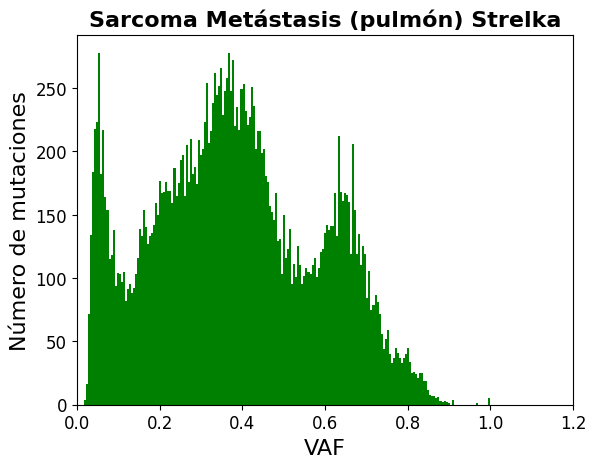

In [55]:
# Represent VAF from Strelka table (indels+snv)
plt.hist(strelka_all_df['VAF'].tolist(), bins = 200, color = "green")
plt.xlim([0,1.2]) 
plt.ylabel('Número de mutaciones', fontsize=16)
plt.xlabel('VAF', fontsize=16)
plt.title('Sarcoma Metástasis (pulmón) Strelka', fontsize=16, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('/workspace/projects/sjd_melos/exports_images/density_vaf_strelka_lung.png',dpi=300,transparent=True, format='png', bbox_inches='tight')
plt.show(strelka_all_df['VAF'].tolist()) 

In [56]:
# saving this table as a tsv file in directory project
# strelka_all_df.to_csv('/workspace/projects/sjd_melos/MAFs_tables/Lung_Strelka_VAF_all.tsv.gz', sep ='\t', index=None, compression = "gzip")

# 4/ Represent VAF considering SNPs and INDEL mutations

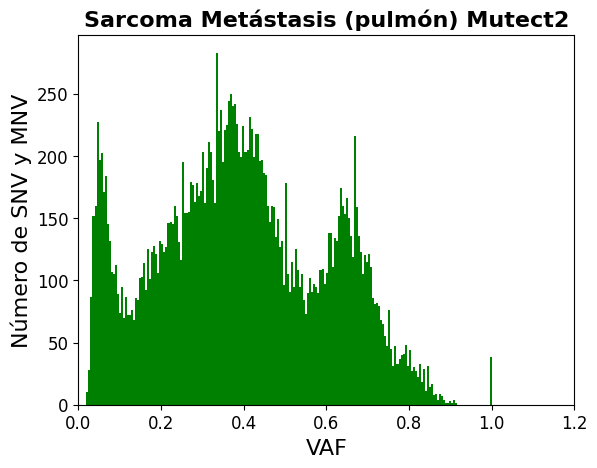

In [57]:
# Now represent VAF of each indel for Mutect and Strelka SNV/INDEL tables obtained above

# For SNV in Mutect2
plt.hist(vaf_mutect_snv_df['VAF'].tolist(), bins = 200, color = "green")
plt.xlim([0,1.2])
plt.ylabel('Número de SNV y MNV', fontsize=16)
plt.xlabel('VAF', fontsize=16)
plt.title('Sarcoma Metástasis (pulmón) Mutect2', fontsize=16, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('/workspace/projects/sjd_melos/exports_images/density_vaf_mutect_snv_lung.png',dpi=300,transparent=True, format='png', bbox_inches='tight')
plt.show(vaf_mutect_snv_df['VAF'].tolist())  

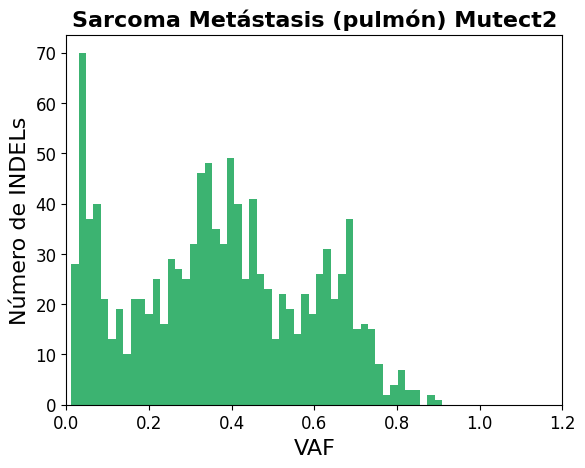

In [58]:
# For INDELs in Mutect2

plt.hist(vaf_mutect_indels_df['VAF'].tolist(), bins = 50, color = "mediumseagreen")
plt.xlim([0,1.2])
plt.ylabel('Número de INDELs', fontsize=16)
plt.xlabel('VAF', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Sarcoma Metástasis (pulmón) Mutect2', fontsize=16, weight='bold')
plt.savefig('/workspace/projects/sjd_melos/exports_images/density_vaf_mutect_indels_lung.png',dpi=300,transparent=True, format='png', bbox_inches='tight')
plt.show(vaf_mutect_indels_df['VAF'].tolist())  

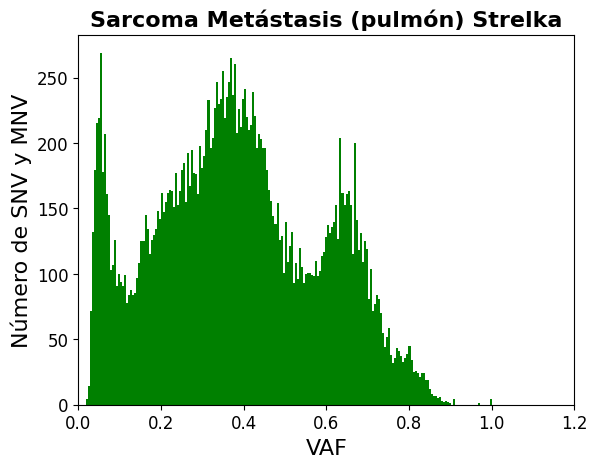

In [59]:
# For SNV in Strelka (the caller does not distinguish between MNV an SNV)

plt.hist(vaf_strelka_snv_df['VAF'].tolist(), bins = 200, color = "green")
plt.xlim([0,1.2]) 
plt.ylabel('Número de SNV y MNV', fontsize=16)
plt.xlabel('VAF', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Sarcoma Metástasis (pulmón) Strelka', fontsize=16, weight='bold')
plt.savefig('/workspace/projects/sjd_melos/exports_images/density_vaf_strelka_snv_lung.png',dpi=300,transparent=True, format='png', bbox_inches='tight')
plt.show(vaf_strelka_snv_df['VAF'].tolist()) 

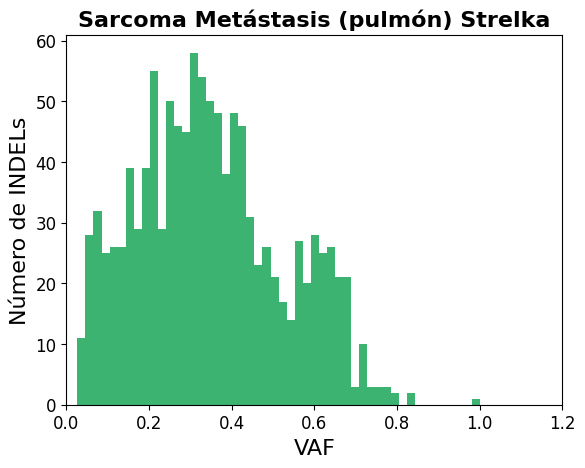

In [60]:
# For INDELs in Strelka

plt.hist(vaf_strelka_ind_df['VAF'].tolist(), bins = 50, color = "mediumseagreen")
plt.ylabel('Número de INDELs', fontsize=16)
plt.xlim([0,1.2]) 
plt.xlabel('VAF', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Sarcoma Metástasis (pulmón) Strelka', fontsize=16, weight='bold')
plt.savefig('/workspace/projects/sjd_melos/exports_images/density_vaf_strelka_indels_lung.png',dpi=300,transparent=True, format='png', bbox_inches='tight')
plt.show(vaf_strelka_ind_df['VAF'].tolist()) 